In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score
from imblearn.over_sampling import SMOTE
import warnings
import joblib

# Suppress specific warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Load the dataset
data = pd.read_csv('medical_blood_test_dataset.csv')

In [21]:
# Drop irrelevant columns
data = data.drop(['Patient_ID', 'Name', 'Region'], axis=1)

# Define numerical and categorical columns based on the dataset
numerical_cols = ['Age', 'BMI', 'Hemoglobin', 'WBC', 'RBC', 'Platelets', 'Glucose_Fasting', 'HbA1c', 
                  'Cholesterol_Total', 'Triglycerides', 'LDL', 'HDL', 'ALT', 'AST', 'Bilirubin_Total', 
                  'Creatinine', 'Urea', 'TSH', 'T3', 'T4', 'CRP']

# Replace negative values with NaN for biologically implausible values
for col in numerical_cols:
    data.loc[data[col] < 0, col] = np.nan

# Handle missing values for numerical columns
num_imputer = SimpleImputer(strategy='median')
data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])

# Define categorical columns
categorical_cols = ['Gender', 'Smoker', 'Alcohol_Intake', 'Exercise_Freq', 'COVID_Antigen_Pos', 
                    'HIV_Positive', 'Hepatitis_B_Pos', 'Hepatitis_C_Pos', 'Malaria_Positive', 'Tuberculosis_Pos']

# Handle missing values for categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])

In [22]:
# Encode categorical variables
# Handle 'Gender' with 'Other' by mapping to a numeric value (e.g., 2 for 'Other')
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
data['Smoker'] = data['Smoker'].map({'No': 0, 'Yes': 1})
data['Alcohol_Intake'] = data['Alcohol_Intake'].map({'None': 0, 'Low': 1, 'Moderate': 2, 'High': 3})

# Map binary categorical columns
binary_cols = ['COVID_Antigen_Pos', 'HIV_Positive', 'Hepatitis_B_Pos', 'Hepatitis_C_Pos', 'Malaria_Positive', 'Tuberculosis_Pos']
for col in binary_cols:
    data[col] = data[col].map({'No': 0, 'Yes': 1})

# One-hot encode Exercise_Freq
data = pd.get_dummies(data, columns=['Exercise_Freq'], prefix='Exercise')


In [23]:
# Define features and target
X = data.drop('Disease', axis=1)
y = data['Disease']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [24]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numerical_cols])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_cols, index=X_train.index)
X_train_scaled = pd.concat([X_train_scaled, X_train.drop(columns=numerical_cols)], axis=1)

X_test_scaled = scaler.transform(X_test[numerical_cols])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical_cols, index=X_test.index)
X_test_scaled = pd.concat([X_test_scaled, X_test.drop(columns=numerical_cols)], axis=1)

# Adjusted SMOTE: Partial oversampling to avoid overfitting
majority_class_count = y_train.value_counts().max()
sampling_strategy = {}
for cls, count in y_train.value_counts().items():
    if count >= majority_class_count // 2:
        # Keep classes with counts >= majority_class_count // 2 unchanged
        sampling_strategy[cls] = count
    else:
        # Oversample minority classes to at least 100 or up to majority_class_count // 2
        target = max(100, min(count * 2, majority_class_count // 2))
        sampling_strategy[cls] = target

# Print class distribution and sampling strategy for debugging
print("Class distribution in y_train:\n", y_train.value_counts())
print("\nSampling strategy:\n", sampling_strategy)

Class distribution in y_train:
 Disease
Diabetes Mellitus          1967
Healthy                    1685
Low HDL Syndrome            545
Obesity-Linked Syndrome     454
Cardiovascular Risk         404
High Cholesterol            306
Elevated Inflammation       305
Liver Disease               295
Anemia                      234
COVID-19                    226
Malaria                     143
Hepatitis B                 102
Hypothyroidism               92
Hepatitis C                  69
Alcoholic Liver Disease      51
Tuberculosis                 45
HIV/AIDS                     39
Kidney Disease               21
Viral Infection              15
Sepsis                        2
Name: count, dtype: int64

Sampling strategy:
 {'Diabetes Mellitus': 1967, 'Healthy': 1685, 'Low HDL Syndrome': np.int64(983), 'Obesity-Linked Syndrome': 908, 'Cardiovascular Risk': 808, 'High Cholesterol': 612, 'Elevated Inflammation': 610, 'Liver Disease': 590, 'Anemia': 468, 'COVID-19': 452, 'Malaria': 286, 'Hepatit

In [25]:
# Adjust k_neighbors for SMOTE based on the smallest class size
min_class_size = y_train.value_counts().min()
k_neighbors = max(1, min_class_size - 1)  # Ensure at least 1 neighbor, but not more than available
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42, k_neighbors=k_neighbors)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Train RandomForestClassifier with balanced class weights
model = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=10)
model.fit(X_train_smote, y_train_smote)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [26]:
# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluation Metrics
print("\nWeighted F1-score:", f1_score(y_test, y_pred, average='weighted'))
print("Weighted Recall:", recall_score(y_test, y_pred, average='weighted'))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Weighted F1-score: 0.9682376249439538
Weighted Recall: 0.962

Confusion Matrix:
 [[ 22   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0 100   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0  96   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   1]
 [ 11   0   0 161   0   1   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   2   0 830   0   1   0   1   3   0   2   0   0   0   0   0   2
    1   1]
 [ 11   0   0   1   0 118   0   1   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0  16   0   0   1   0   0   0   0   0   0   0   0
    0   0]
 [ 40   0   0   4   0   0   0 678   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0  43   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0  29   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0 129   0   0   0   1   0   


Feature Importance (Top 10):
              feature  importance
17        Creatinine    0.081833
15               AST    0.080770
3     Alcohol_Intake    0.078623
25      HIV_Positive    0.076903
20               LDL    0.074206
27   Hepatitis_C_Pos    0.073891
29  Tuberculosis_Pos    0.072818
2             Smoker    0.072050
28  Malaria_Positive    0.067060
26   Hepatitis_B_Pos    0.063296


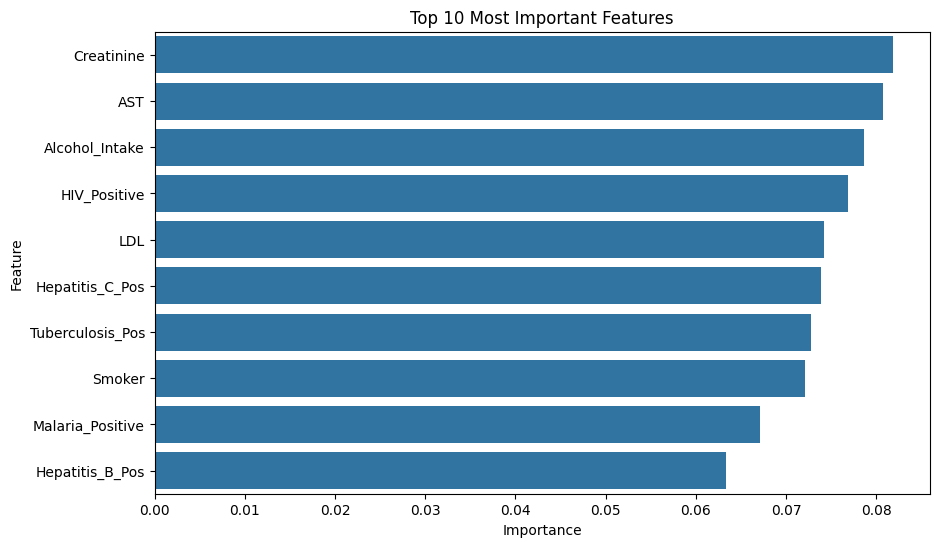

In [27]:
# Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)
print("\nFeature Importance (Top 10):\n", feature_importance.head(10))

# Visualize Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [28]:
# Cross-Validation
cv_scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring='f1_weighted')
print("\nCross-validation F1-scores:", cv_scores)
print("Mean CV F1-score:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

# Adjust Prediction Thresholds for Minority Classes
probabilities = model.predict_proba(X_test_scaled)
minority_classes = ['HIV/AIDS', 'Hepatitis C', 'Tuberculosis', 'Malaria', 'Hepatitis B']
minority_indices = [list(model.classes_).index(cls) for cls in minority_classes if cls in model.classes_]
threshold = 0.3  # Lower threshold for minority classes
y_pred_adjusted = np.argmax(probabilities, axis=1)
for i, prob in enumerate(probabilities):
    for idx in minority_indices:
        if prob[idx] > threshold:
            y_pred_adjusted[i] = idx
            break
y_pred_adjusted = [model.classes_[idx] for idx in y_pred_adjusted]
print("\nWeighted F1-score (with adjusted thresholds):", f1_score(y_test, y_pred_adjusted, average='weighted'))
print("Weighted Recall (with adjusted thresholds):", recall_score(y_test, y_pred_adjusted, average='weighted'))



Cross-validation F1-scores: [0.94908345 0.96256577 0.96754332 0.96305465 0.96415066]
Mean CV F1-score: 0.9612795680385003
Standard Deviation: 0.00634079321037735

Weighted F1-score (with adjusted thresholds): 0.9584256690994504
Weighted Recall (with adjusted thresholds): 0.9516666666666667


In [29]:
# Test on new data (example input)
# Ensure Exercise_Freq matches the original dataset's categories
new_data = pd.DataFrame({
    'Age': [45], 'Gender': [0], 'BMI': [27.5], 'Hemoglobin': [14.2], 'WBC': [6.5], 'RBC': [4.8], 
    'Platelets': [250], 'Glucose_Fasting': [95], 'HbA1c': [5.5], 'Cholesterol_Total': [190], 
    'Triglycerides': [130], 'LDL': [110], 'HDL': [50], 'ALT': [25], 'AST': [20], 
    'Bilirubin_Total': [0.8], 'Creatinine': [0.9], 'Urea': [20], 'TSH': [2.5], 
    'T3': [1.2], 'T4': [8.0], 'CRP': [2.0], 'Smoker': [0], 'Alcohol_Intake': [1], 
    'COVID_Antigen_Pos': [0], 'HIV_Positive': [0], 'Hepatitis_B_Pos': [0], 'Hepatitis_C_Pos': [0], 
    'Malaria_Positive': [0], 'Tuberculosis_Pos': [0], 'Exercise_Freq': ['Never']  # Use raw category
})

# One-hot encode Exercise_Freq in new_data consistently with training
new_data = pd.get_dummies(new_data, columns=['Exercise_Freq'], prefix='Exercise')

# Align new_data columns with X_train_scaled
missing_cols = set(X_train_scaled.columns) - set(new_data.columns)
for col in missing_cols:
    new_data[col] = 0
new_data = new_data[X_train_scaled.columns]  # Reorder to match X_train_scaled

# Scale numerical features
new_data_scaled = scaler.transform(new_data[numerical_cols])
new_data_scaled = pd.DataFrame(new_data_scaled, columns=numerical_cols, index=new_data.index)
new_data_scaled = pd.concat([new_data_scaled, new_data.drop(columns=numerical_cols)], axis=1)

# Predict
new_pred = model.predict(new_data_scaled)
new_pred_proba = model.predict_proba(new_data_scaled)
print("\nPrediction for new_data:", new_pred[0])
print("Prediction probabilities:", dict(zip(model.classes_, new_pred_proba[0])))



Prediction for new_data: Healthy
Prediction probabilities: {'Alcoholic Liver Disease': np.float64(0.0694552164246957), 'Anemia': np.float64(0.031243120229958392), 'COVID-19': np.float64(0.046626627911402645), 'Cardiovascular Risk': np.float64(0.09044807994992876), 'Diabetes Mellitus': np.float64(0.05525708957410688), 'Elevated Inflammation': np.float64(0.09617990248134371), 'HIV/AIDS': np.float64(0.02624047449116311), 'Healthy': np.float64(0.10626744463830294), 'Hepatitis B': np.float64(0.035781315737533424), 'Hepatitis C': np.float64(0.02621688076995021), 'High Cholesterol': np.float64(0.05106221459452641), 'Hypothyroidism': np.float64(0.02230960337784417), 'Kidney Disease': np.float64(0.025732794017478532), 'Liver Disease': np.float64(0.06913968929276962), 'Low HDL Syndrome': np.float64(0.07200080008818716), 'Malaria': np.float64(0.030086578062852466), 'Obesity-Linked Syndrome': np.float64(0.07400574329715753), 'Sepsis': np.float64(0.012790968446431301), 'Tuberculosis': np.float64(0

# ------- 

In [50]:
joblib.dump(model, 'rf_disease_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']

In [ ]:
# Update predict_disease function similarly
def predict(new_data):
    modelrf = joblib.load('models\rf_disease_model.pkl')
    scalerrf = joblib.load('models\scaler.pkl') 

    # One-hot encode Exercise_Freq
    new_data = pd.get_dummies(new_data, columns=['Exercise_Freq'], prefix='Exercise')
    # Align columns
    missing_cols = set(X_train_scaled.columns) - set(new_data.columns)
    for col in missing_cols:
        new_data[col] = 0
    new_data = new_data[X_train_scaled.columns]
    # Scale numerical features
    new_data_scaled = scalerrf.transform(new_data[numerical_cols])
    new_data_scaled = pd.DataFrame(new_data_scaled, columns=numerical_cols, index=new_data.index)
    new_data_scaled = pd.concat([new_data_scaled, new_data.drop(columns=numerical_cols)], axis=1)
    # Predict
    prediction = modelrf.predict(new_data_scaled)[0]
    probabilities = modelrf.predict_proba(new_data_scaled)[0]
    prob_dict = dict(zip(modelrf.classes_, probabilities))
    sorted_probs = sorted(prob_dict.items(), key=lambda x: x[1], reverse=True)
    print(f"\nPredicted Disease: {prediction}")
    print(f"Confidence: {prob_dict[prediction]*100:.2f}%")
    print("Other possibilities:")
    for disease, prob in sorted_probs[1:5]:
        if prob > 0.005:  # Show only if probability > 0.5%
            print(f"{disease}: {prob*100:.2f}%")


In [54]:
predict(pd.DataFrame({
    'Age': [70], 'Gender': [1], 'BMI': [26.0], 'Hemoglobin': [14.0], 'WBC': [6.0], 'RBC': [4.9], 
    'Platelets': [260], 'Glucose_Fasting': [90], 'HbA1c': [5.4], 'Cholesterol_Total': [180], 
    'Triglycerides': [120], 'LDL': [105], 'HDL': [55], 'ALT': [22], 'AST': [20], 
    'Bilirubin_Total': [0.8], 'Creatinine': [1.0], 'Urea': [21], 'TSH': [2.7], 
    'T3': [1.2], 'T4': [8.2], 'CRP': [3.0], 'Smoker': [1], 'Alcohol_Intake': [1], 
    'COVID_Antigen_Pos': [0], 'HIV_Positive': [0], 'Hepatitis_B_Pos': [0], 'Hepatitis_C_Pos': [0], 
    'Malaria_Positive': [0], 'Tuberculosis_Pos': [0], 'Exercise_Freq': ['Occasionally']
}))


Predicted Disease: Healthy
Confidence: 10.66%
Other possibilities:
Elevated Inflammation: 9.57%
Cardiovascular Risk: 8.91%
Obesity-Linked Syndrome: 7.45%
Low HDL Syndrome: 7.24%


In [55]:
predict(pd.DataFrame({
    'Age': [35], 'Gender': [0], 'BMI': [35.5], 'Hemoglobin': [13.0], 'WBC': [9.5], 'RBC': [4.7], 
    'Platelets': [220], 'Glucose_Fasting': [110], 'HbA1c': [6.0], 'Cholesterol_Total': [210], 
    'Triglycerides': [200], 'LDL': [130], 'HDL': [35], 'ALT': [35], 'AST': [30], 
    'Bilirubin_Total': [0.9], 'Creatinine': [1.2], 'Urea': [28], 'TSH': [3.5], 
    'T3': [0.9], 'T4': [7.0], 'CRP': [15.0], 'Smoker': [0], 'Alcohol_Intake': [1], 
    'COVID_Antigen_Pos': [0], 'HIV_Positive': [0], 'Hepatitis_B_Pos': [0], 'Hepatitis_C_Pos': [0], 
    'Malaria_Positive': [0], 'Tuberculosis_Pos': [1], 'Exercise_Freq': ['Rarely']
}))


Predicted Disease: Sepsis
Confidence: 38.09%
Other possibilities:
Tuberculosis: 37.50%
Low HDL Syndrome: 6.76%
Diabetes Mellitus: 6.01%
Malaria: 3.31%


In [60]:
predict(pd.DataFrame({
    'Age': [50], 'Gender': [1], 'BMI': [28.0], 'Hemoglobin': [12.8], 'WBC': [8.0], 'RBC': [4.2], 
    'Platelets': [180], 'Glucose_Fasting': [100], 'HbA1c': [5.7], 'Cholesterol_Total': [200], 
    'Triglycerides': [150], 'LDL': [120], 'HDL': [40], 'ALT': [50], 'AST': [45], 
    'Bilirubin_Total': [1.5], 'Creatinine': [1.0], 'Urea': [22], 'TSH': [2.8], 
    'T3': [1.1], 'T4': [8.5], 'CRP': [10.0], 'Smoker': [1], 'Alcohol_Intake': [3], 
    'COVID_Antigen_Pos': [0], 'HIV_Positive': [0], 'Hepatitis_B_Pos': [0], 'Hepatitis_C_Pos': [1], 
    'Malaria_Positive': [0], 'Tuberculosis_Pos': [0], 'Exercise_Freq': ['Never']
}))


Predicted Disease: Hepatitis C
Confidence: 60.59%
Other possibilities:
Alcoholic Liver Disease: 7.86%
Sepsis: 7.10%
Diabetes Mellitus: 3.87%
Low HDL Syndrome: 2.94%


In [61]:
predict(pd.DataFrame({
    'Age': [60], 'Gender': [1], 'BMI': [30.2], 'Hemoglobin': [13.5], 'WBC': [7.2], 'RBC': [4.5], 
    'Platelets': [200], 'Glucose_Fasting': [140], 'HbA1c': [6.8], 'Cholesterol_Total': [220], 
    'Triglycerides': [180], 'LDL': [140], 'HDL': [45], 'ALT': [30], 'AST': [25], 
    'Bilirubin_Total': [1.0], 'Creatinine': [1.1], 'Urea': [25], 'TSH': [3.0], 
    'T3': [1.0], 'T4': [7.5], 'CRP': [5.0], 'Smoker': [1], 'Alcohol_Intake': [2], 
    'COVID_Antigen_Pos': [0], 'HIV_Positive': [0], 'Hepatitis_B_Pos': [0], 'Hepatitis_C_Pos': [0], 
    'Malaria_Positive': [0], 'Tuberculosis_Pos': [0], 'Exercise_Freq': ['Rarely']
}))


Predicted Disease: Diabetes Mellitus
Confidence: 52.03%
Other possibilities:
Obesity-Linked Syndrome: 11.40%
Healthy: 4.28%
Elevated Inflammation: 3.74%
Low HDL Syndrome: 3.60%


In [62]:
predict(pd.DataFrame({
    'Age': [25], 'Gender': [0], 'BMI': [22.5], 'Hemoglobin': [15.0], 'WBC': [5.8], 'RBC': [5.0], 
    'Platelets': [300], 'Glucose_Fasting': [85], 'HbA1c': [5.0], 'Cholesterol_Total': [160], 
    'Triglycerides': [90], 'LDL': [100], 'HDL': [60], 'ALT': [20], 'AST': [18], 
    'Bilirubin_Total': [0.7], 'Creatinine': [0.8], 'Urea': [18], 'TSH': [2.0], 
    'T3': [1.3], 'T4': [9.0], 'CRP': [1.0], 'Smoker': [0], 'Alcohol_Intake': [0], 
    'COVID_Antigen_Pos': [0], 'HIV_Positive': [0], 'Hepatitis_B_Pos': [0], 'Hepatitis_C_Pos': [0], 
    'Malaria_Positive': [0], 'Tuberculosis_Pos': [0], 'Exercise_Freq': ['Regularly']
}))


Predicted Disease: Healthy
Confidence: 10.80%
Other possibilities:
Elevated Inflammation: 9.42%
Cardiovascular Risk: 8.69%
Obesity-Linked Syndrome: 7.46%
Low HDL Syndrome: 7.31%


In [63]:
# Test the function
predict(pd.DataFrame({
    'Age': [45], 'Gender': [0], 'BMI': [27.5], 'Hemoglobin': [14.2], 'WBC': [6.5], 'RBC': [4.8], 
    'Platelets': [250], 'Glucose_Fasting': [95], 'HbA1c': [5.5], 'Cholesterol_Total': [190], 
    'Triglycerides': [130], 'LDL': [110], 'HDL': [50], 'ALT': [25], 'AST': [20], 
    'Bilirubin_Total': [0.8], 'Creatinine': [0.9], 'Urea': [20], 'TSH': [2.5], 
    'T3': [1.2], 'T4': [8.0], 'CRP': [2.0], 'Smoker': [0], 'Alcohol_Intake': [1], 
    'COVID_Antigen_Pos': [0], 'HIV_Positive': [0], 'Hepatitis_B_Pos': [0], 'Hepatitis_C_Pos': [0], 
    'Malaria_Positive': [0], 'Tuberculosis_Pos': [0], 'Exercise_Freq': ['Never']
}))



Predicted Disease: Healthy
Confidence: 10.63%
Other possibilities:
Elevated Inflammation: 9.62%
Cardiovascular Risk: 9.04%
Obesity-Linked Syndrome: 7.40%
Low HDL Syndrome: 7.20%
